# <center> ADCIRC Example - Data-Consistent Inversion </center>

___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

- [***Parameter Estimation with Maximal Updated Densities***](https://arxiv.org/pdf/2212.04587.pdf) Pilosov, M., del-Castillo-Negrete, C., Yen, T. Y., Butler, T., & Dawson, C. (2022). Parameter Estimation with Maximal Updated Densities. arXiv preprint arXiv:2212.04587.
___


<cite id="e9b62"><a href="#zotero%7C11450669%2F7F6J6S7U">(Wicks &#38; Atkinson, 2017)</a></cite>


____

## Getting dataset

If running from within DesignSafe, data should be under the project directory PRJ-3492 at the path `~/NHERI-Published/PRJ-3492/` in your jupyter instance.

Otherwise [download published dataset](https://doi.org/10.17603/ds2-bmrf-y737) and place in same path as this notebook.

In [1]:
!ls ~/NHERI-Published/PRJ-3492/

ls: cannot access '/home/jovyan/NHERI-Published/PRJ-3492/': No such file or directory


In [2]:
import pickle
from pathlib import Path
path = str(Path.home() /'NHERI-Published/PRJ-3492/si-inlet-full-ds.pickle')
path = str(Path.cwd() / 'si-inlet-full-ds.pickle')

In [3]:
from pydci.utils import put_df, add_noise
import numpy as np
import pandas as pd

def build_dataset(path,
                  lam_true_idx=-1,
                  num_samples=999,
                 std_dev= 0.05,
                 seed=None):
    
    with open(path, 'rb') as fp:
        full_ds = pickle.load(fp)
    full_ds


    all_lam = np.vstack([full_ds['lam'], full_ds['lam_ref'].reshape(1, -1)])
    all_data = np.vstack([full_ds['data'], full_ds['true_vals'].reshape(1, -1)])
    
    measurements = add_noise(all_data[[lam_true_idx]], std_dev, seed=seed).reshape(-1, 1)
    data_df = pd.DataFrame(full_ds['times'], columns=['ts'])
    data_df['shift_idx'] = 0
    data_df['sample_flag'] = True
    for i, val in enumerate(all_lam[lam_true_idx]):
        data_df[f'lam_true_{i}'] = val
    data_df = put_df(data_df, 'q_lam_true', all_data[lam_true_idx].reshape(-1, 1))
    data_df = put_df(data_df, 'q_lam_obs', measurements)
    
    sample_idxs = np.random.choice(len(all_lam), num_samples, replace=False)
    lam_true_idx = len(all_lam) - 1 if lam_true_idx == -1 else lam_true_idx
    sample_idxs = [x for x in sample_idxs if x != lam_true_idx]

    lam_df = pd.DataFrame(all_lam[sample_idxs], columns=[f'lam_{i}' for i in range(len(full_ds['lam'][0]))])
    q_lam_df = pd.DataFrame(all_data[sample_idxs], columns=[f'q_lam_{i}' for i in range(len(full_ds['data'][0]))])
    samples_df = pd.concat([lam_df, q_lam_df], axis=1)
    
    return full_ds, data_df, samples_df, measurements


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pdb


def plot_state(data, samples=None, mask=None, plot_intervals=None):
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    
    mask = data.index.values if mask is None else mask
    sns.lineplot(data.iloc[mask], x='ts', y='q_lam_true_0', label='True State', ax=ax)
    sns.scatterplot(data.iloc[mask], x='ts', y='q_lam_obs_0', marker='*', label='Observed State', ax=ax)

    if samples is not None:
        cols = [c for c in samples.columns if c.startswith('q_lam_') and int(c.split('_')[-1]) in mask]
        num_plot = 10
        for idx, i in enumerate(np.random.choice(range(len(samples)), num_plot, replace=False)):
            to_plot = pd.DataFrame(samples.iloc[[i]][cols].values.T, columns=[f'q_lam_s={i}'])
            to_plot['ts'] = data.iloc[mask]['ts'].values
            label = None if idx != num_plot - 1 else 'Samples'
            sns.lineplot(to_plot, x='ts', y=f'q_lam_s={i}', ax=ax, color='r', alpha=0.1, label=label)

    plot_intervals = [] if plot_intervals is None else plot_intervals 
    for (name, args, intervals) in plot_intervals:
        for interval in intervals:
            ax.axvline(data['ts'][interval[0]], **args)
        args['label'] = name
        ax.axvline(data['ts'][intervals[-1][-1]], **args)

    # ax.set_title('Time Window 3')
    # ax.set_title(f'lam_true = {data["lam_true_0"].values[0]}, {data["lam_true_1"].values[0]}')
    ax.set_ylabel('Water Elevation (m)')
    ax.set_xlabel('Time')
    ax.legend()

In [5]:
import matplotlib.pyplot as plt

def plot_params(state_df, full_ds):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))                       
    prob.plot_L(df=state_df, param_idx=0, lam_true=[full_ds['lam_ref']], ax=ax[0])
    prob.plot_L(df=state_df, param_idx=1, lam_true=[full_ds['lam_ref']], ax=ax[1])
    
    return ax


In [6]:
def split_range(mask, n_splits=2):
    n_ts = max(mask) - min(mask)
    splits = range(min(mask), max(mask), int(int(n_ts)/n_splits))
    start = min(mask)
    ranges = []
    if n_splits == 1:
        return [range(min(mask), max(mask))]
    for s in splits[1:]:
        ranges.append(range(start, s))
        start = s
    return ranges

In [7]:
import seaborn as sns

def plot_iterations(prob, 
                   max_plot=10,
                   plot_idxs=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    if plot_idxs is None:
        num_its = prob.pca_states['iteration'].max()
        if num_its > max_plot:
            plot_idxs = list(range(0, num_its, int(num_its/max_plot)))
            if (num_its - 1) not in plot_idxs:
                plot_idxs += [num_its - 1]
        else:
            plot_idxs = range(0, num_its)
    
    
    label = f"$\pi^{{in}}_{0}$"
    sns.kdeplot(prob.state, x='lam_0', ax=ax[0], label=label)
    sns.kdeplot(prob.state, x='lam_1', ax=ax[1], label=label)
    for (idx, state) in prob.pca_states.groupby('iteration'):
        if idx in plot_idxs:
            label = f"$\pi^{{up}}_{{{idx}}}$"
            sns.kdeplot(state, x='lam_0', weights=state['weight'] * state['ratio'], ax=ax[0], label=label)
            sns.kdeplot(state, x='lam_1', weights=state['weight'] * state['ratio'], ax=ax[1], label=label)
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel('$\lambda_1$')
    ax[1].set_xlabel('$\lambda_2$')

In [8]:
std_dev =0.05
seed=21
full_ds, data_df, samples_df, measurements = build_dataset(path, seed=seed, std_dev=std_dev)

In [9]:
data_df

,ts,shift_idx,sample_flag,lam_true_0,lam_true_1,q_lam_true_0,q_lam_obs_0
0,2018-01-01 00:03:00,0,True,0.067243,0.002568,-0.160002,-0.162600
1,2018-01-01 00:06:00,0,True,0.067243,0.002568,-0.159192,-0.164751
2,2018-01-01 00:09:00,0,True,0.067243,0.002568,-0.158108,-0.106019
3,2018-01-01 00:12:00,0,True,0.067243,0.002568,-0.156425,-0.219262
4,2018-01-01 00:15:00,0,True,0.067243,0.002568,-0.154186,-0.116916
...,...,...,...,...,...,...,...
6128,2018-01-13 23:45:00,0,True,0.067243,0.002568,-0.156296,-0.126368
6129,2018-01-13 23:48:00,0,True,0.067243,0.002568,-0.167302,-0.212053
6130,2018-01-13 23:51:00,0,True,0.067243,0.002568,-0.178476,-0.254657
6131,2018-01-13 23:54:00,0,True,0.067243,0.002568,-0.189576,-0.240698


In [10]:
samples_df

,lam_0,lam_1,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5,q_lam_6,q_lam_7,...,q_lam_6123,q_lam_6124,q_lam_6125,q_lam_6126,q_lam_6127,q_lam_6128,q_lam_6129,q_lam_6130,q_lam_6131,q_lam_6132
0,0.093865,0.002217,-0.098529,-0.098187,-0.097603,-0.096297,-0.094471,-0.092910,-0.092280,-0.092804,...,-0.031317,-0.040351,-0.050015,-0.060054,-0.070415,-0.081188,-0.092421,-0.103996,-0.115751,-0.127697
1,0.073952,0.002513,-0.149888,-0.149366,-0.148671,-0.147051,-0.144599,-0.142349,-0.141211,-0.141387,...,-0.096050,-0.105088,-0.114628,-0.124460,-0.134574,-0.145131,-0.156176,-0.167739,-0.179283,-0.191110
2,0.059847,0.001664,0.009024,0.009842,0.010425,0.010887,0.011452,0.011629,0.010814,0.008978,...,0.088413,0.079203,0.069547,0.059593,0.049343,0.038682,0.027550,0.016001,0.004138,-0.007969
3,0.040349,0.001561,0.030676,0.031019,0.031184,0.031288,0.031271,0.030790,0.029591,0.027613,...,0.109560,0.100329,0.090722,0.080934,0.070816,0.060206,0.049101,0.037551,0.025542,0.013429
4,0.049240,0.003691,-0.115084,-0.112887,-0.110688,-0.107900,-0.104600,-0.101529,-0.099412,-0.098575,...,-0.053479,-0.063066,-0.073423,-0.084119,-0.095033,-0.106318,-0.118181,-0.130594,-0.143590,-0.156585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.055597,0.002976,-0.150908,-0.148516,-0.146042,-0.142579,-0.138269,-0.134226,-0.131524,-0.130446,...,-0.096083,-0.105813,-0.116276,-0.127136,-0.138285,-0.149806,-0.161832,-0.174512,-0.187535,-0.200639
994,0.060459,0.002982,-0.180696,-0.177620,-0.174413,-0.170387,-0.165490,-0.160565,-0.157006,-0.155492,...,-0.128567,-0.137712,-0.147994,-0.159056,-0.170856,-0.183221,-0.195793,-0.208266,-0.221700,-0.235379
995,0.049044,0.002823,-0.113886,-0.111741,-0.109616,-0.106887,-0.103613,-0.100548,-0.098421,-0.097572,...,-0.051925,-0.061532,-0.071904,-0.082644,-0.093631,-0.104994,-0.116927,-0.129399,-0.142426,-0.155378
996,0.036092,0.002299,-0.036399,-0.034519,-0.032745,-0.030712,-0.028603,-0.027022,-0.026373,-0.026784,...,0.038204,0.028407,0.017975,0.007227,-0.003762,-0.015099,-0.026851,-0.038969,-0.051372,-0.064029


# Time Window 3

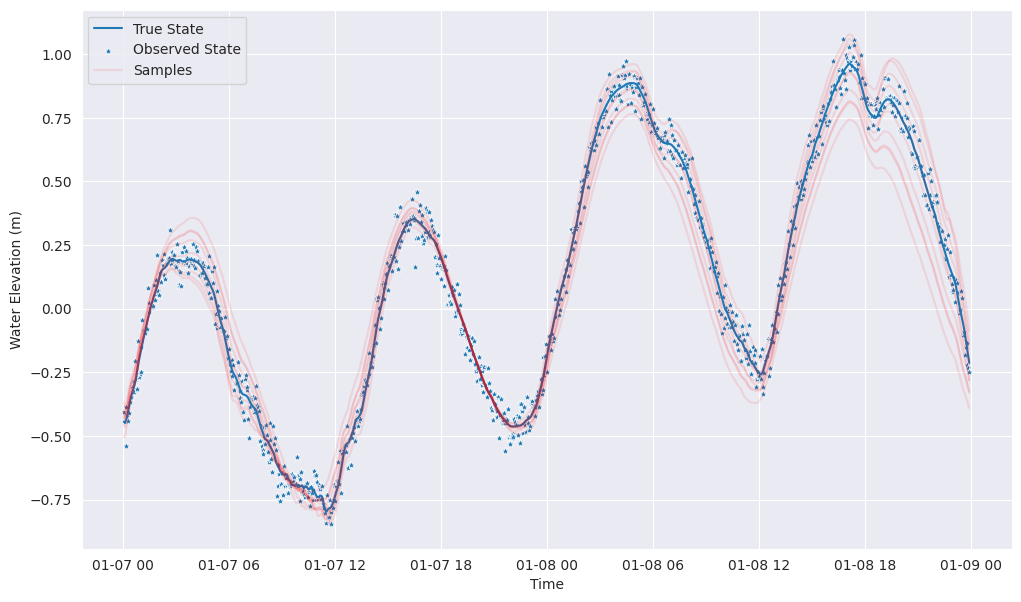

In [11]:
t3 = ["2018-01-07 00:00:00", "2018-01-09 00:00:00"]
t3_mask = data_df.index[(data_df['ts'] > t3[0]) & (data_df['ts'] < t3[1])].values
t3_mask = range(min(t3_mask), max(t3_mask))
plot_state(data_df, samples_df, t3_mask)

### Solving Using $Q_{PCA}$ Map

In [12]:
from pydci import PCAMUDProblem

pca = PCAMUDProblem(samples_df, measurements, std_dev)
pca.solve(pca_components=[0, 1], pca_mask=t3_mask)
pca.result

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask
0,0.908784,5.935119,0.069212,0.002584,438,"[0, 1]","range(2774, 3732)"


(<Axes: xlabel='$\\Lambda$', ylabel='Density'>,
 ['$\\pi^{up}_{\\lambda_1}$',
  '$\\pi^{in}_{\\lambda_1}$',
  '$\\lambda^{\\dagger}_1 = 0.0026$',
  '$\\lambda^{MUD}_1 = 0.0026$'])

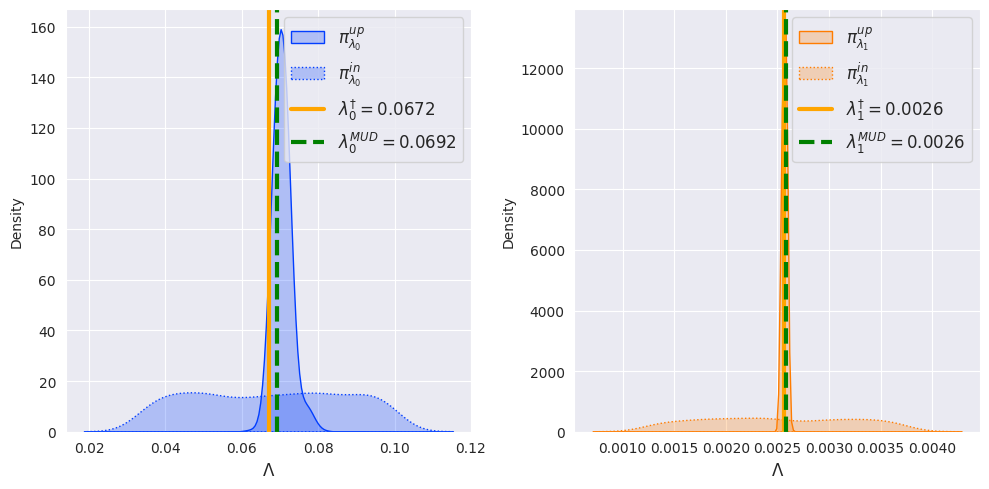

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))                       
pca.plot_L(param_idx=0, lam_true=[full_ds['lam_ref']], ax=ax[0])
pca.plot_L(param_idx=1, lam_true=[full_ds['lam_ref']], ax=ax[1])

## Using 2, 5, 10 splits

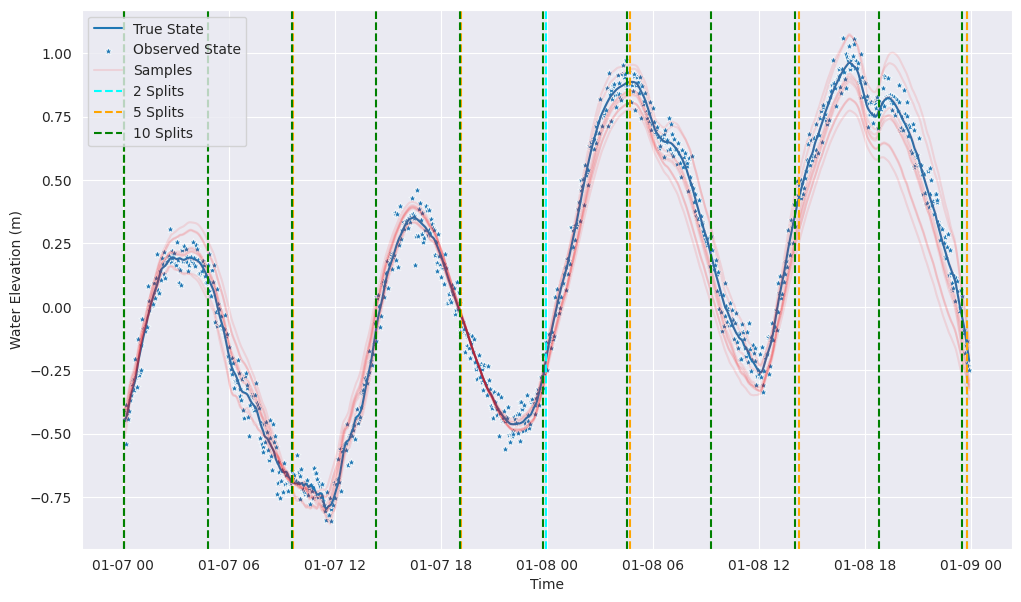

In [19]:
intervals_2 =split_range(t3_mask, 2)
intervals_5 =split_range(t3_mask, 5)
intervals_10 =split_range(t3_mask, 10)

plot_intervals = [('2 Splits', {'color': 'cyan', 'linestyle': '--'}, intervals_2),
                  ('5 Splits', {'color': 'orange', 'linestyle': '--'}, intervals_5),
                  ('10 Splits', {'color': 'green', 'linestyle': '--'}, intervals_10)]

plot_state(data_df, samples_df, t3_mask, plot_intervals=plot_intervals)

In [20]:
pca_2 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_2.solve_it(pca_splits=intervals_2, pca_components=[[0]])
pca_2.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,0.92873,2.532213,0.078406,0.002391,250,[0],"range(2774, 3252)",0
0,0.84499,1.812942,0.056920,0.003015,591,[0],"range(3252, 3730)",1


In [29]:
mud_states = get_df(pca.state.iloc[pca_2.it_results['MUD_idx'].values], 'q_lam', pca.n_qoi)
np.linalg.norm((mud_states.T - measurements).T, axis=1)
# np.linalg.norm(np.subtract(mud_states.T, measurements), axis=1)


array([7.8160638 , 7.20815497])

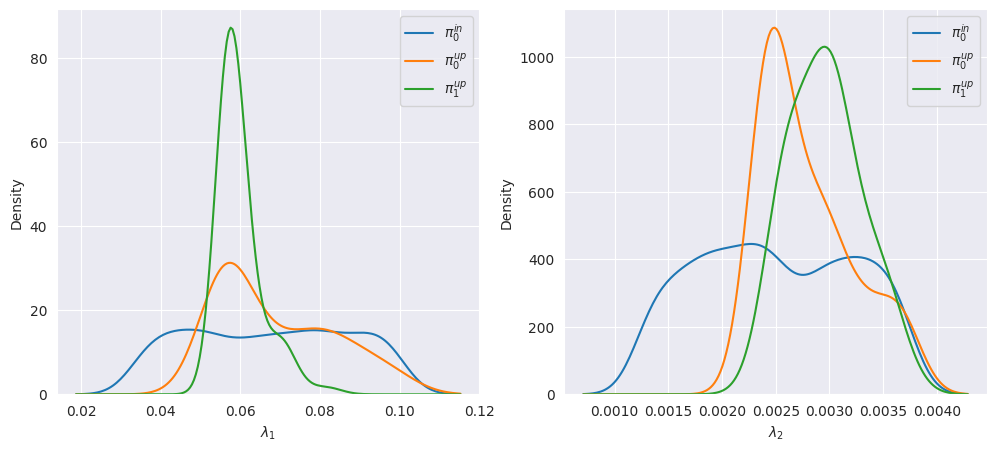

In [17]:
plot_iterations(pca_2, plot_idxs=[0, 1])

In [18]:
pca_5 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_5.solve_it(pca_splits=intervals_5, pca_components=[[0]], exp_thresh=0.9)
pca_5.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,i
0,1.103372,2.267444,0.050972,0.002684,[0],"range(2774, 2965)",0
0,0.361242,1.913475,0.061655,0.002603,[0],"range(2965, 3156)",1
0,0.851774,0.793676,0.063742,0.002642,[0],"range(3156, 3347)",2
0,1.039910,0.311512,0.061655,0.002603,[0],"range(3347, 3538)",3
0,1.640791,0.962530,0.061655,0.002603,[0],"range(3538, 3729)",4


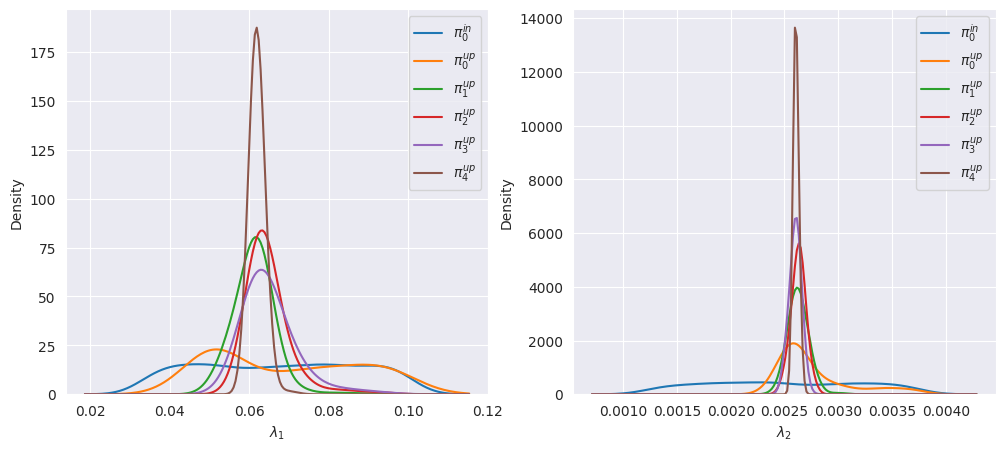

In [19]:
plot_iterations(pca_5, plot_idxs=range(5))

In [20]:
pca_10 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_10.solve_it(pca_splits=intervals_10, pca_components=[[0]], exp_thresh=0.9)
pca_10.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,i
0,1.136705,1.590017,0.082026,0.002509,[0],"range(2774, 2869)",0
0,0.948890,1.055957,0.087825,0.002599,[0],"range(2869, 2964)",1
0,0.870930,1.274999,0.063742,0.002642,[0],"range(2964, 3059)",2
0,0.825661,1.152791,0.063742,0.002642,[0],"range(3059, 3154)",3
0,0.627650,1.419713,0.063742,0.002642,[0],"range(3154, 3249)",4
0,0.813468,0.213183,0.063742,0.002642,[0],"range(3249, 3344)",5
0,1.118783,0.574686,0.082026,0.002509,[0],"range(3344, 3439)",6
0,0.977481,0.046133,0.082026,0.002509,[0],"range(3439, 3534)",7
0,NaN,3.322235,0.063742,0.002642,[0],"range(3534, 3629)",8
0,NaN,3.322235,0.063742,0.002642,[0],"range(3629, 3724)",9


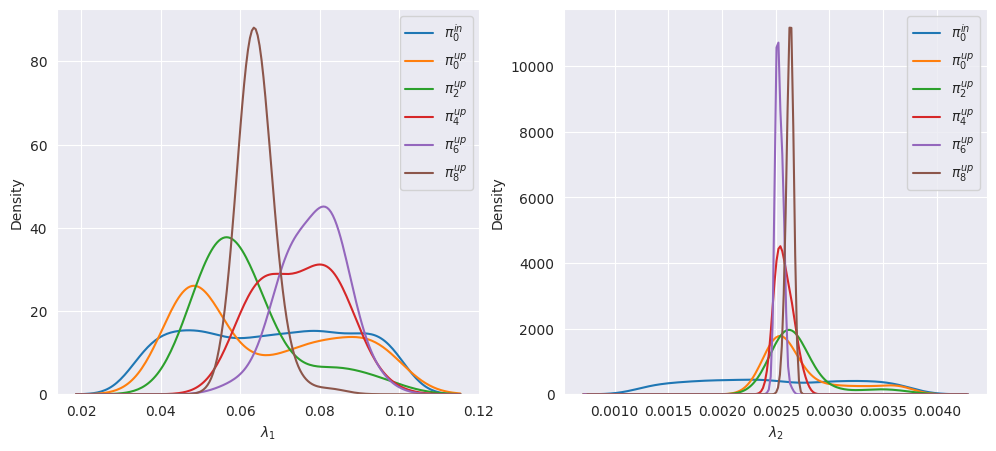

In [21]:
plot_iterations(pca_10, plot_idxs=range(0, 11, 2))

In [22]:
intervals_100 =split_range(t3_mask, 100)
pca_100 = PCAMUDProblem(samples_df, measurements, std_dev)
pca_100.solve_it(pca_splits=intervals_100, pca_components=[[0]], exp_thresh=1e10)
pca_100.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,pca_components,pca_mask,i
0,0.940010,0.734217,0.045694,0.002448,[0],"range(2774, 2783)",0
0,0.776341,0.325736,0.043783,0.002889,[0],"range(2783, 2792)",1
0,0.484568,0.228164,0.040309,0.002846,[0],"range(2792, 2801)",2
0,0.632904,0.621168,0.040309,0.002846,[0],"range(2801, 2810)",3
0,0.932077,0.263342,0.040309,0.002846,[0],"range(2810, 2819)",4
...,...,...,...,...,...,...,...
0,0.613731,1.520979,0.069212,0.002584,[0],"range(3683, 3692)",101
0,0.484923,1.900473,0.063742,0.002642,[0],"range(3692, 3701)",102
0,1.065529,0.163713,0.063742,0.002642,[0],"range(3701, 3710)",103
0,0.126415,3.825857,0.063742,0.002642,[0],"range(3710, 3719)",104


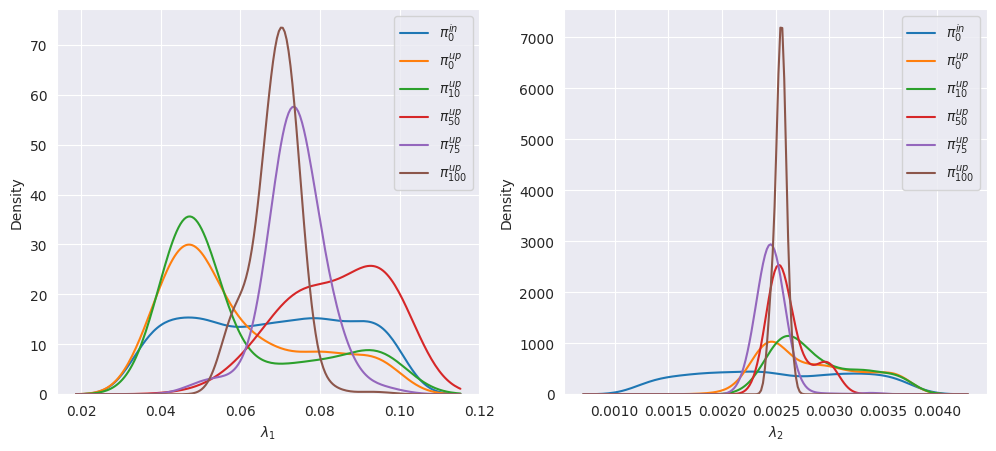

In [23]:
plot_iterations(pca_100, plot_idxs=[0, 10, 50, 75, 100])

# Repeating Trials

In [95]:
from alive_progress import alive_bar 

def process_result(prob, lam_true):
    # Calculate L2 error and Covariance for each
    res = prob.it_results.copy()
    mud_points = get_df(prob.it_results, 'lam_MUD', 2)
    l2_errs = np.linalg.norm(mud_points - full_ds['lam_ref'], axis=1)
    l2_errs = np.linalg.norm(mud_points - full_ds['lam_ref'], axis=1)
    covs = []
    lam_matrix = get_df(prob.state, 'lam', 2)
    for idx, state in prob.pca_states.groupby('iteration'):
        cov = np.cov(lam_matrix.T, aweights=state['ratio'])
        covs.append([cov[0][0], cov[1][1]])
    covs = np.array(covs)
    res['l2_err'] = l2_errs
    res['lam_0_cov'] = covs[:,0]
    res['lam_1_cov'] = covs[:,1]

    mud_states = get_df(prob.state.iloc[prob.it_results['MUD_idx'].values], 'q_lam', prob.n_qoi)
    res['state_err'] = np.linalg.norm((mud_states.T - measurements).T, axis=1)

    res['i'] = res['i'] + 1
    res['ts'] = [full_ds['times'][int(x.split(',')[-1][1:-1])] for x in res['pca_mask'].values]
    first = res.iloc[[0]].copy()
    first['i'] = 0
    first['ts'] = [full_ds['times'][eval(res['pca_mask'].values[0])[0]]]
    res = pd.concat([first, res])
    res['splits'] = res['i'].max()
    return res

def split_scan(n_splits, std_dev=0.05, num_samples=999, n_trials=10):
    
    all_results = []
    
    with alive_bar(len(n_splits)*n_trials, title=f'Scanning {n_splits} using {num_samples}', force_tty=True) as bar:
        for n in range(n_trials):
            full_ds, data_df, samples_df, measurements = build_dataset(path, std_dev=std_dev, num_samples=num_samples)
            for ns in n_splits:
                intervals =split_range(t3_mask, ns)
                pca = PCAMUDProblem(samples_df, measurements, std_dev)
                pca_components = [[0, 1]] if ns == 1 else [[0]]
                pca.solve_it(pca_splits=intervals, pca_components=pca_components, exp_thresh=1e10)
                
                all_results.append(process_result(pca, full_ds['lam_ref']))
                bar()

    all_results = pd.concat(all_results)
    
    return all_results

def incremental_scan(num_splits=100,
                     std_dev=0.05,
                     num_samples=999,
                     exp_thresh=1e10,
                     pca_components=[[0, 1]],
                     n_trials=10):
    
    all_results = []
    
    with alive_bar(n_trials * num_splits, title=f'Scanning {num_splits} using {num_samples}', force_tty=True) as bar:
        for n in range(n_trials):
            full_ds, data_df, samples_df, measurements = build_dataset(path, std_dev=std_dev, num_samples=num_samples)
            intervals =split_range(t3_mask, num_splits)
            start = intervals[0][0]
            for interval in intervals:
                pca = PCAMUDProblem(samples_df, measurements, std_dev)
                pca.solve_it(pca_splits=[range(start, max(interval))], pca_components=pca_components, exp_thresh=1e10)
                all_results.append(process_result(pca, full_ds['lam_ref']))
                bar()

    all_results = pd.concat(all_results)
    
    return all_results

def plot_scan_results(results):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax3 = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax4 = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax5 = plt.subplots(1, 1, figsize=(10, 5))
    fig, ax6 = plt.subplots(1, 1, figsize=(10, 5))

    for idx, res in results.groupby('splits'):
        sns.lineplot(res.dropna(), x='ts', y='e_r', label=f'{idx} Intervals', ax=ax1)
        sns.lineplot(res.dropna(), x='ts', y='kl', label=f'{idx} Intervals', ax=ax2)
        sns.lineplot(res.dropna(), x='ts', y='l2_err', label=f'{idx} Intervals', ax=ax3)
        sns.lineplot(res.dropna(), x='ts', y='state_err', label=f'{idx} Intervals', ax=ax4)
        sns.lineplot(res.dropna(), x='ts', y='lam_0_cov', label=f'{idx} Intervals', ax=ax5)
        sns.lineplot(res.dropna(), x='ts', y='lam_1_cov', label=f'{idx} Intervals', ax=ax6)

    [ax.set_xlabel('Time') for ax in [ax1, ax2, ax3, ax4, ax5, ax6]]
    ax1.set_ylabel('$\mathbb{E}(r)$')
    ax2.set_ylabel('$\mathcal{D}_{KL}$')
    ax3.set_ylabel('$||\lambda^{MUD} - \lambda^{\dagger}||_{\ell_2}$')
    ax4.set_ylabel('$||Q(\lambda^{MUD}) - Q(\lambda^{\dagger})||_{\ell_2}$')
    ax5.set_ylabel('$\sigma_0$')
    ax6.set_ylabel('$\sigma_1$')

In [ ]:
inc_scan = incremental_scan(num_splits=100, std_dev=std_dev, n_trials=10)

Scanning 100 using 999 |█████████████████▌                      | ▁▃▅ 438/1000 [44%] in 4:52 (~6:15, 1.5/s)             |████▊                                   | ▃▁▃ 119/1000 [12%] in 1:19 (~9:48, 1.5/s) 

In [55]:
split_results = split_scan([5, 10, 100], std_dev=std_dev, n_trials=10)

on 10: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in scalar divide
         fact = w_sum - ddof*sum(w*aweights)/w_sum


Scanning [1, 10, 100] using 999 |████████████████████████████████████████| 30/30 [100%] in 1:34.5 (0.31/s)              


In [ ]:
all_results = pd.concat([inc_scan, split_results])

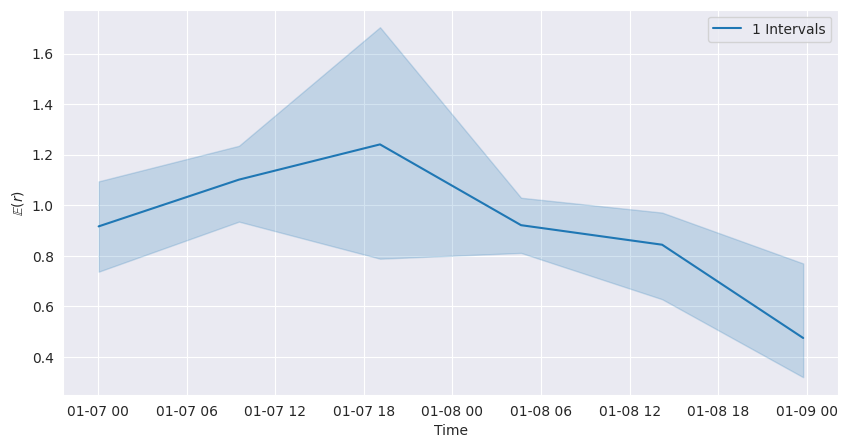

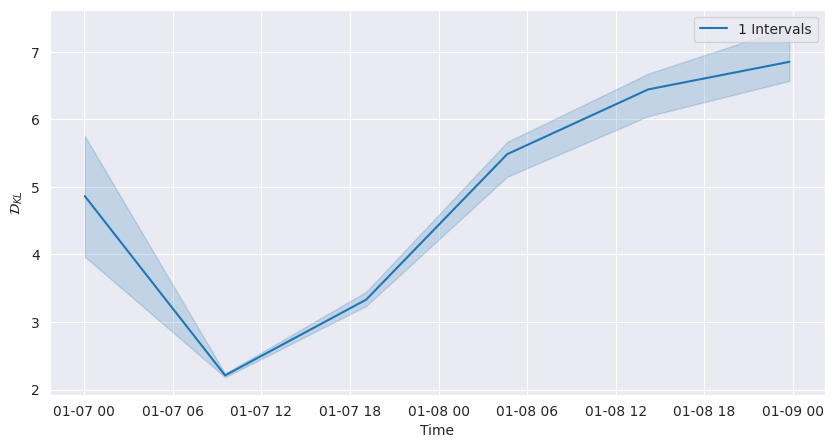

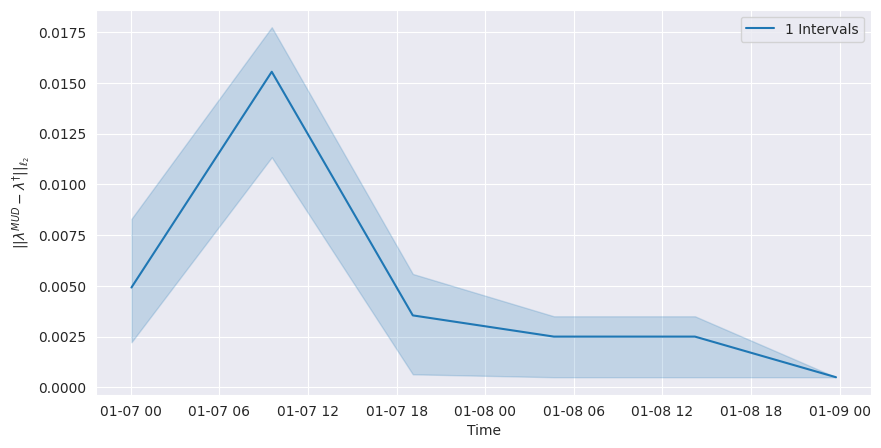

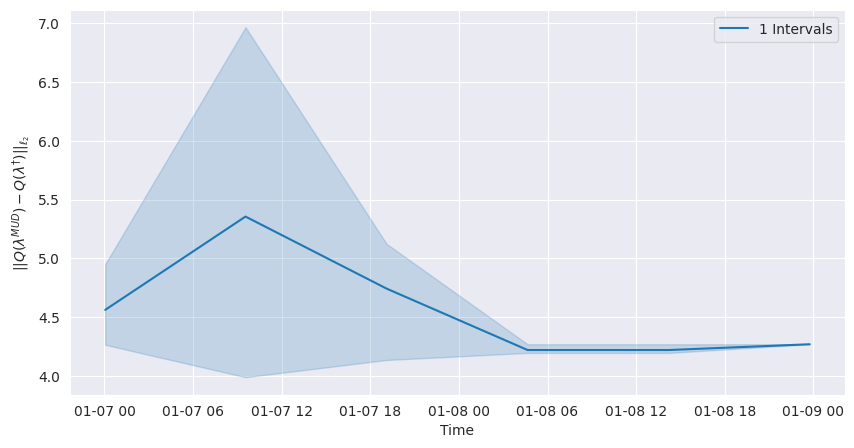

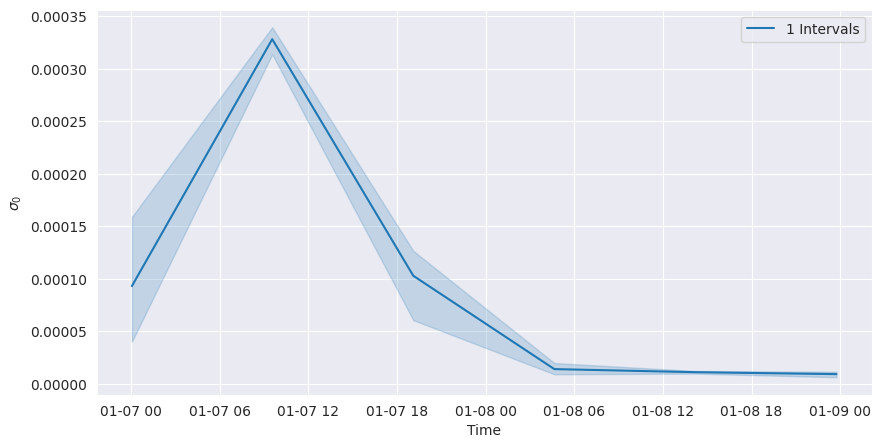

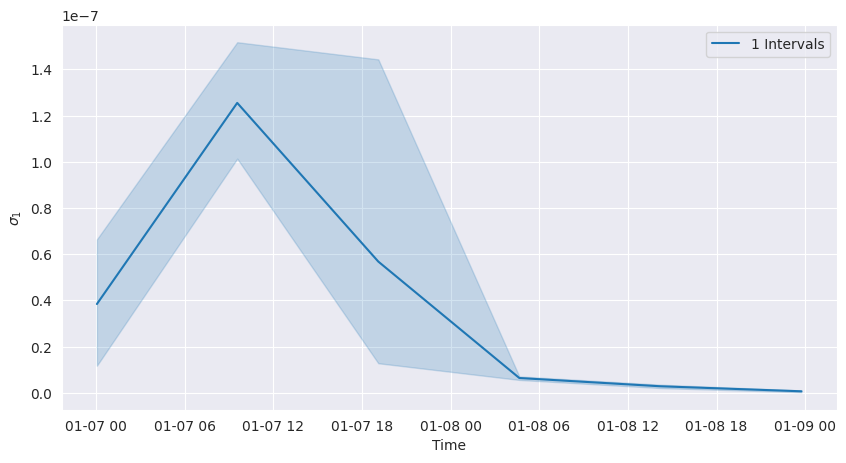

In [94]:
plot_scan_results(all_results)

Text(0, 0.5, '$\\mathcal{D}_{KL}$')

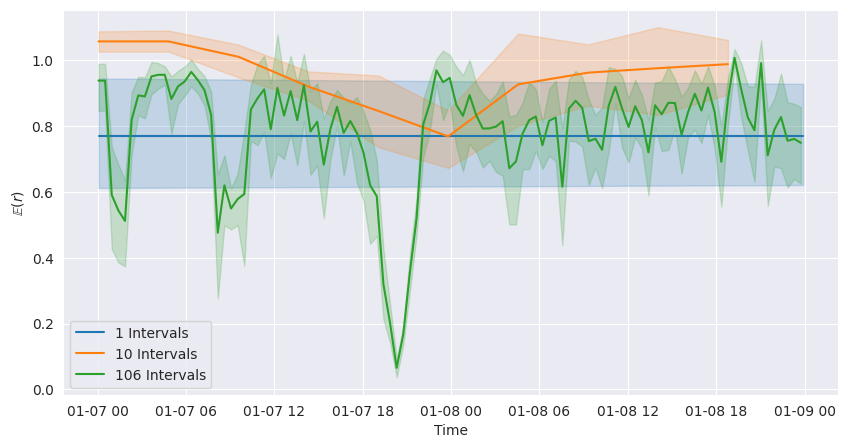

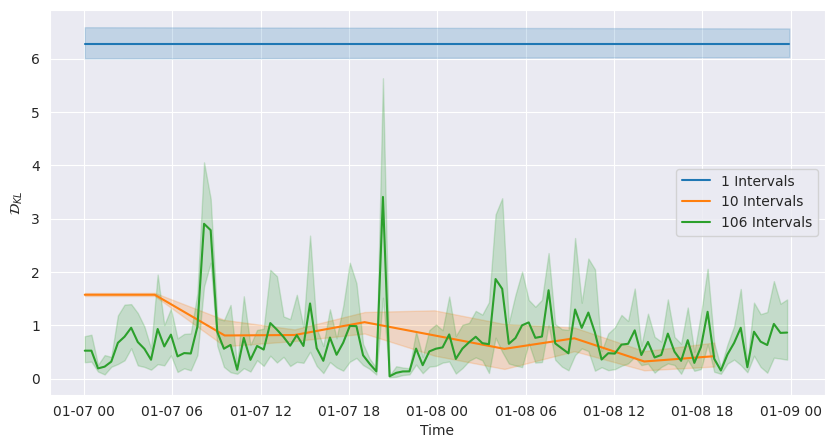

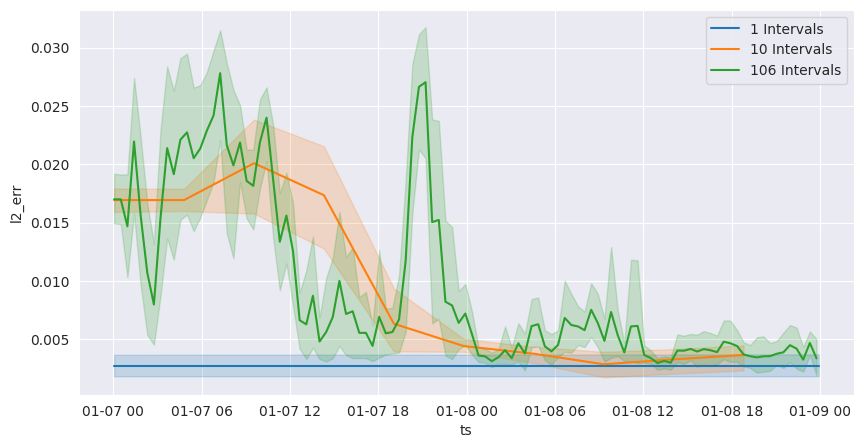

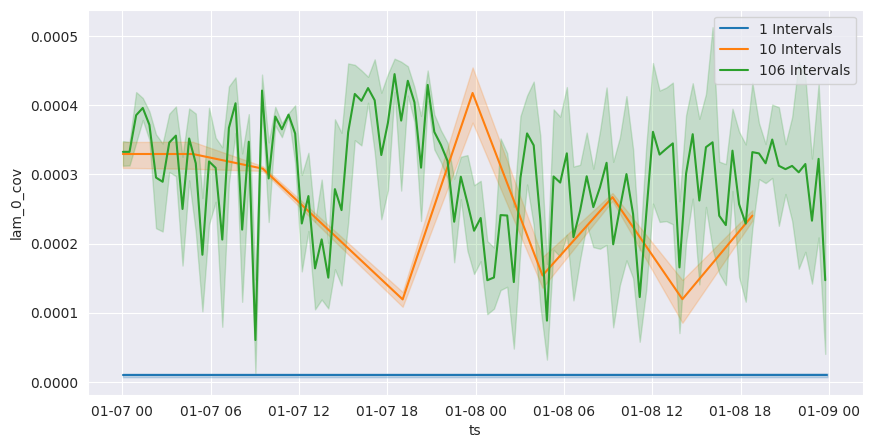

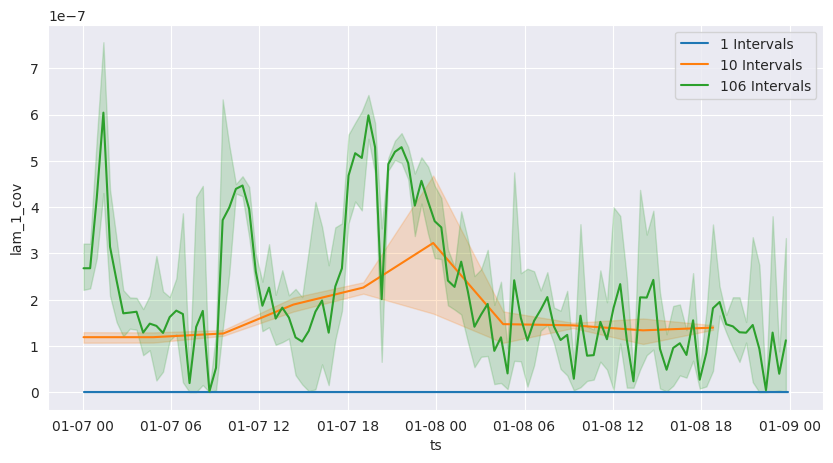

In [57]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax3 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax4 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax5 = plt.subplots(1, 1, figsize=(10, 5))

for idx, res in scan_results.groupby('splits'):
    sns.lineplot(res.dropna(), x='ts', y='e_r', label=f'{idx} Intervals', ax=ax1)
    sns.lineplot(res.dropna(), x='ts', y='kl', label=f'{idx} Intervals', ax=ax2)
    sns.lineplot(res.dropna(), x='ts', y='l2_err', label=f'{idx} Intervals', ax=ax3)
    sns.lineplot(res.dropna(), x='ts', y='lam_0_cov', label=f'{idx} Intervals', ax=ax4)
    sns.lineplot(res.dropna(), x='ts', y='lam_1_cov', label=f'{idx} Intervals', ax=ax5)

ax1.set_xlabel('Time')
ax1.set_ylabel('$\mathbb{E}(r)$')
ax2.set_xlabel('Time')
ax2.set_ylabel('$\mathcal{D}_{KL}$')

## Using Less Samples

In [35]:
scan_results = split_scan([1, 5, 10, 50, 100], std_dev=std_dev, n_trials=10, num_samples=100)

on 17: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in scalar divide
         fact = w_sum - ddof*sum(w*aweights)/w_sum


on 22: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_30115/1985566889.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
         cov = np.cov(lam_matrix.T, aweights=state['ratio'])
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
         c *= np.true_divide(1, fact)


on 27: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


on 33: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: overflow encountered in multiply
         fact = w_sum - ddof*sum(w*aweights)/w_sum
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in scalar divide
         fact = w_sum - ddof*sum(w*aweights)/w_sum


on 37: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


on 47: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/li

on 48: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: overflow encountered in multiply
         fact = w_sum - ddof*sum(w*aweights)/w_sum
/tmp/ipykernel_30115/1985566889.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
         cov = np.cov(lam_matrix.T, aweights=state['ratio'])
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
         c *= np.true_divide(1, fact)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid valu

on 49: /opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in multiply
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
         return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:551: RuntimeWarning: invalid value encountered in divide
         avg = avg_as_array = np.multiply(a, wgt,
/opt/conda/envs/fenix/lib/python3.10/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: overflow encountered in multiply
         fact = w_sum - ddof*sum(w*aweights)/w_sum
/opt/conda/envs/fenix/lib/python3.10/si

Scanning [1, 5, 10, 50, 100] using 100 |████████████████████████████████████████| 50/50 [100%] in 50.0s (0.99/s)        


In [42]:
scan_results[scan_results['splits'] == 100]

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i,l2_err,lam_0_cov,lam_1_cov,state_err,ts,splits
0,0.988647,0.269049,0.056454,0.002244,86,[0],"range(2774, 2783)",0,0.010794,0.000373,3.281206e-07,8.717626,2018-01-07 00:03:00,100
0,0.988647,0.269049,0.056454,0.002244,86,[0],"range(2774, 2783)",1,0.010794,0.000373,3.281206e-07,8.717626,2018-01-07 00:30:00,100
0,0.102927,0.617218,0.069999,0.002698,43,[0],"range(2783, 2792)",2,0.002759,0.000297,1.552628e-07,4.852305,2018-01-07 00:57:00,100
0,0.229857,0.092895,0.069999,0.002698,43,[0],"range(2792, 2801)",3,0.002759,0.000583,3.517012e-08,4.852305,2018-01-07 01:24:00,100
0,0.575477,1.877009,0.069999,0.002698,43,[0],"range(2801, 2810)",4,0.002759,0.000348,3.782801e-08,4.852305,2018-01-07 01:51:00,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.590041,0.695666,0.090697,0.002504,16,[0],"range(3683, 3692)",102,0.023454,0.000514,1.702220e-07,4.971768,2018-01-08 21:57:00,100
0,1.920972,0.494624,0.090697,0.002504,16,[0],"range(3692, 3701)",103,0.023454,0.000580,1.774363e-07,4.971768,2018-01-08 22:24:00,100
0,NaN,inf,0.090697,0.002504,16,[0],"range(3701, 3710)",104,0.023454,NaN,NaN,4.971768,2018-01-08 22:51:00,100
0,NaN,inf,0.090697,0.002504,16,[0],"range(3710, 3719)",105,0.023454,NaN,NaN,4.971768,2018-01-08 23:18:00,100


ValueError: cannot reindex on an axis with duplicate labels

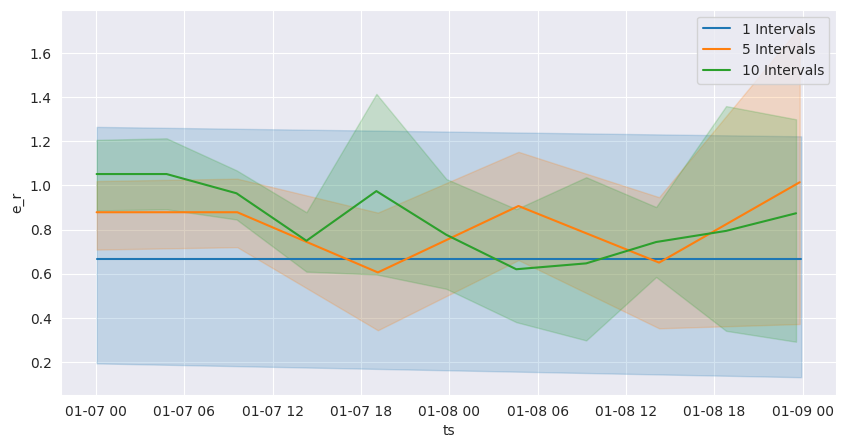

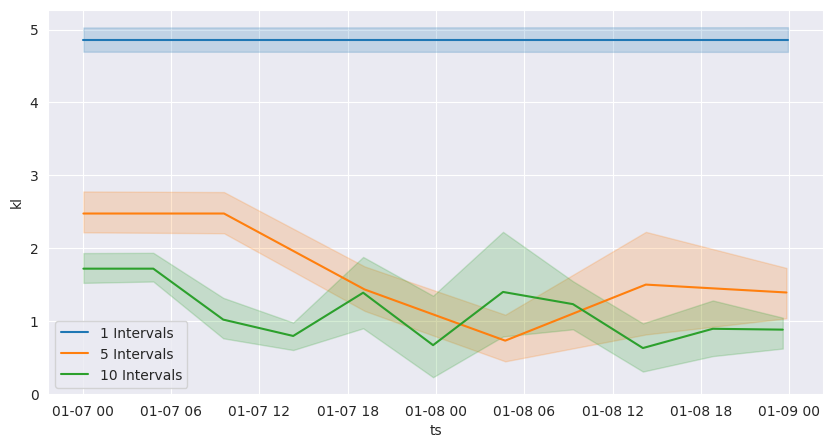

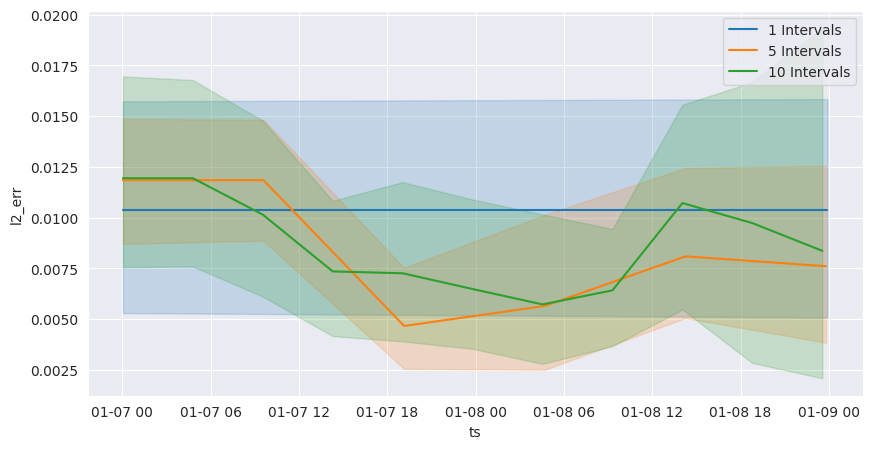

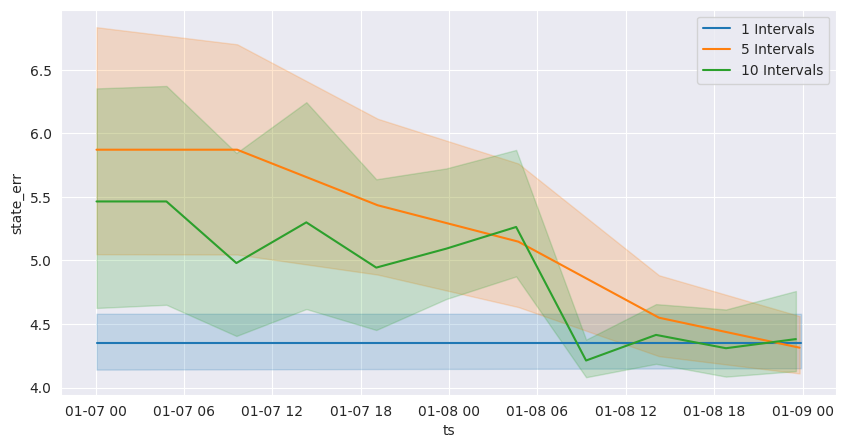

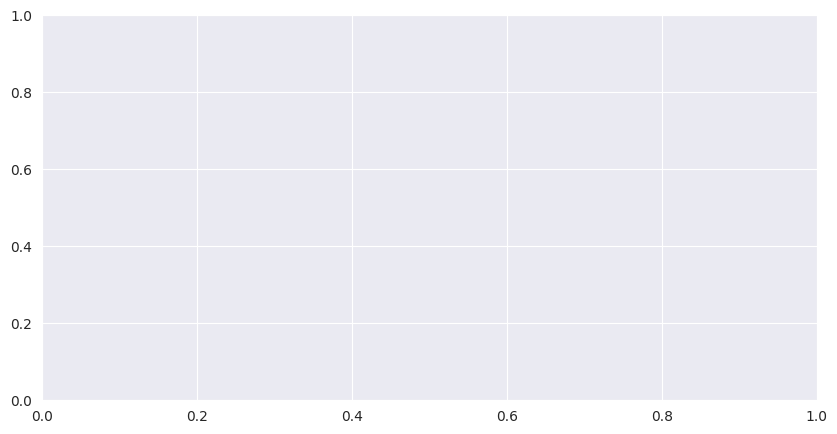

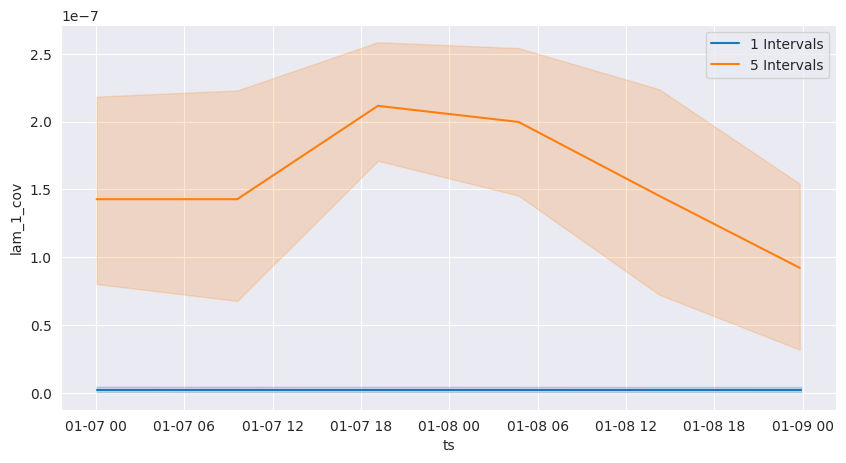

In [44]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax3 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax4 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax5 = plt.subplots(1, 1, figsize=(10, 5))
fig, ax6 = plt.subplots(1, 1, figsize=(10, 5))

for idx, res in scan_results.groupby('splits'):
    sns.lineplot(res.dropna(), x='ts', y='e_r', label=f'{idx} Intervals', ax=ax1)
    sns.lineplot(res.dropna(), x='ts', y='kl', label=f'{idx} Intervals', ax=ax2)
    sns.lineplot(res.dropna(), x='ts', y='l2_err', label=f'{idx} Intervals', ax=ax3)
    sns.lineplot(res.dropna(), x='ts', y='state_err', label=f'{idx} Intervals', ax=ax4)
    # sns.lineplot(res.dropna(), x='ts', y='lam_0_cov', label=f'{idx} Intervals', ax=ax5)
    sns.lineplot(res.dropna(), x='ts', y='lam_1_cov', label=f'{idx} Intervals', ax=ax6)

ax1.set_xlabel('Time')
ax1.set_ylabel('$\mathbb{E}(r)$')
ax2.set_xlabel('Time')
ax2.set_ylabel('$\mathcal{D}_{KL}$')

# Selective Intervals

Using weights only from intervals with good E(r) values.

In [ ]:
thresh = 0.95
good_e_r = pca_100.it_results['i'][(pca_100.it_results['e_r'] > 1 - thresh) & (pca_100.it_results['e_r'] < 1 + thresh)].values
weights = []
for gi in good_e_r:
    weights.append(pca_100.pca_states[pca_100.pca_states['iteration'] == gi]['ratio'].values)

In [ ]:
from pydci.utils import get_df

mud_pt = get_df(pca_100.state.iloc[[np.argmax(np.prod(np.array(weights), axis=0))]], 'lam', 2)
mud_pt, full_ds['lam_ref']

In [ ]:
np.linalg.norm(mud_pt - full_ds['lam_ref'])

In [ ]:
sns.kdeplot(data=pca_100.state, x='lam_0', weights=np.prod(np.array(weights), axis=0))

In [ ]:
sns.kdeplot(data=pca_100.state, x='lam_1', weights=np.prod(np.array(weights), axis=0))

In [ ]:
ratios = pca_100.pca_states[['ratio']].iloc[[x in good_e_r for x in pca_100.pca_states['iteration']]].values.reshape(pca_100.n_samples, len(good_e_r)).T

In [ ]:
pca_100.pca_states

In [ ]:
ratios[0] == pca_100.pca_states[pca_100.pca_states['iteration'] == 0]['ratio']

In [ ]:
sns.kdeplot(data=pca_100.pca_states[pca_100.pca_states['iteration'] == 0], x='lam_0', weights='ratio')

In [ ]:
sns.kdeplot(data=pca_100.pca_states[pca_100.pca_states['iteration'] == 0], x='lam_0', weights=ratios[0])